In [1]:
import cx_Oracle
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
conn = cx_Oracle.connect('js_dev', '123456', 'wind')

In [3]:
query = 'select t.trade_dt, t.s_info_windcode, t.s_val_mv, t.s_val_pe_ttm, t.s_dq_close_today \
         from wind.AShareEODDerivativeIndicator t \
         where t.trade_dt >= \'2010-01-01\' '

In [4]:
df = pd.read_sql_query(query, con=conn)

In [5]:
df.shape

(8509921, 5)

In [6]:
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT'], format='%Y%m%d')

# 市值

In [7]:
mv_df = df.pivot_table('S_VAL_MV', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

# 市盈率

In [8]:
pe_df = df.pivot_table('S_VAL_PE_TTM', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

# 收益率

In [9]:
p_df = df.pivot_table('S_DQ_CLOSE_TODAY', index=['TRADE_DT', 'S_INFO_WINDCODE']).unstack()

In [10]:
r_df = p_df.pct_change()

In [11]:
r_df = r_df.fillna(0)

# Size factor

去除最小的30%市值的股票，然后将剩余股票等比例分成两组

In [12]:
mv_per_df = mv_df.rank(axis=1, pct=True)

In [13]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[(mv_per_df >= 0.3) & (mv_per_df <= 0.65)] = 1
mv_per_df[mv_per_df != 1] = 0

In [14]:
small_ret = (mv_per_df * r_df.shift(-1).values).mean(axis=1)

In [15]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[mv_per_df > 0.65] = 1
mv_per_df[mv_per_df != 1] = 0

In [16]:
big_ret = (mv_per_df * r_df.shift(-1).values).mean(axis=1)

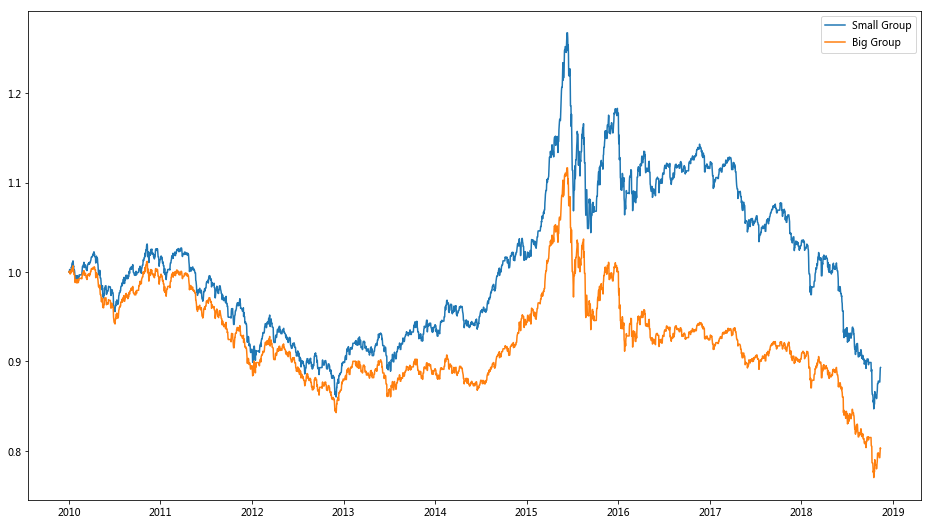

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((1 + small_ret).cumprod(), label='Small Group')
ax.plot((1 + big_ret).cumprod(), label='Big Group')
ax.legend()

In [18]:
ret = small_ret - big_ret

In [19]:
acc = (1 + ret).cumprod()

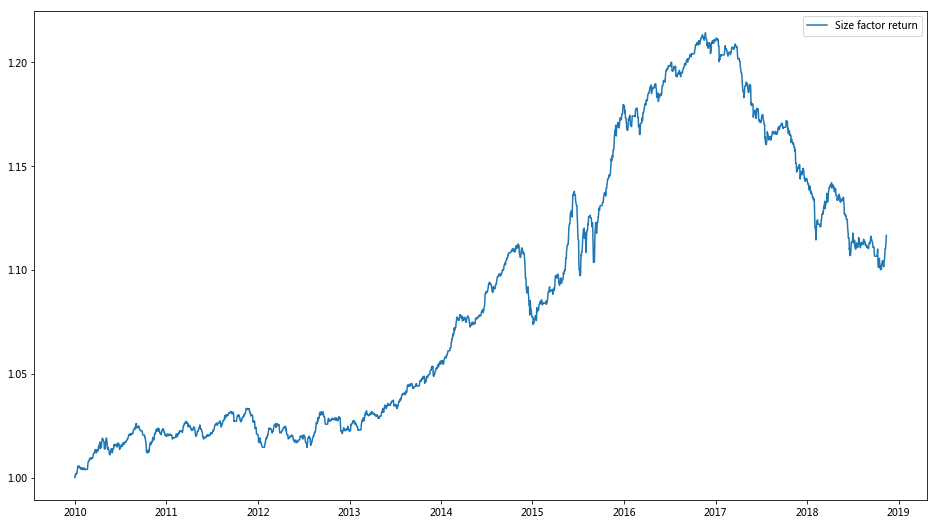

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(acc, label='Size factor return')
ax.legend()

# Value factor

去除最小的30%市值的股票，然后将剩余股票等比例分成三组

In [21]:
mv_per_df = mv_df.rank(axis=1, pct=True)
mv_per_df[mv_per_df >= 0.3] = 1
mv_per_df[mv_per_df < 0.3] = np.nan

In [22]:
pe_df = pe_df * mv_per_df.values

In [23]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[pe_per_df <= 1./3] = 1
pe_per_df[pe_per_df != 1] = 0

In [24]:
value_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

In [25]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[(pe_per_df > 1./3) & (pe_per_df < 2./3)] = 1
pe_per_df[pe_per_df != 1] = 0

In [26]:
middle_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

In [27]:
pe_per_df = pe_df.rank(axis=1, pct=True)
pe_per_df[pe_per_df >= 2./3] = 1
pe_per_df[pe_per_df != 1] = 0

In [28]:
growth_ret = (pe_per_df * r_df.shift(-1).values).mean(axis=1)

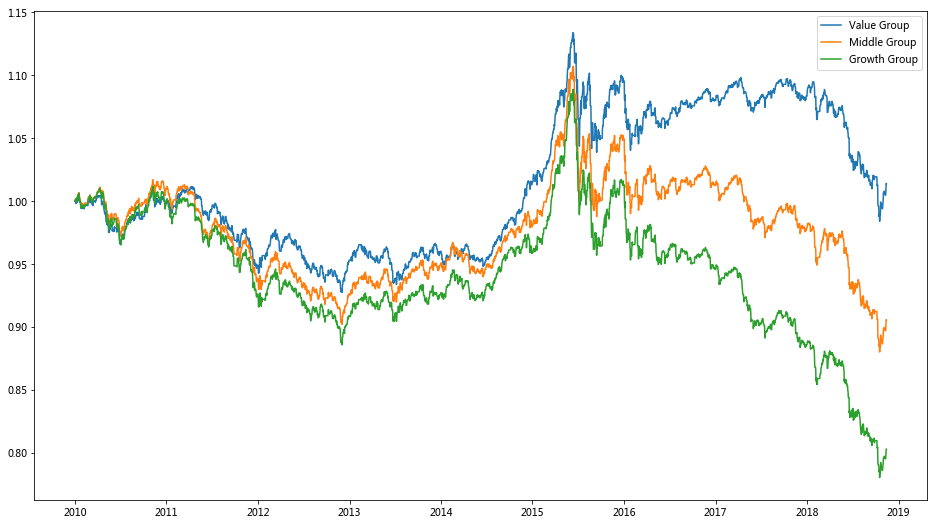

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((1 + value_ret).cumprod(), label='Value Group')
ax.plot((1 + middle_ret).cumprod(), label='Middle Group')
ax.plot((1 + growth_ret).cumprod(), label='Growth Group')
ax.legend()

In [30]:
ret = value_ret - growth_ret

In [31]:
acc = (1 + ret).cumprod()

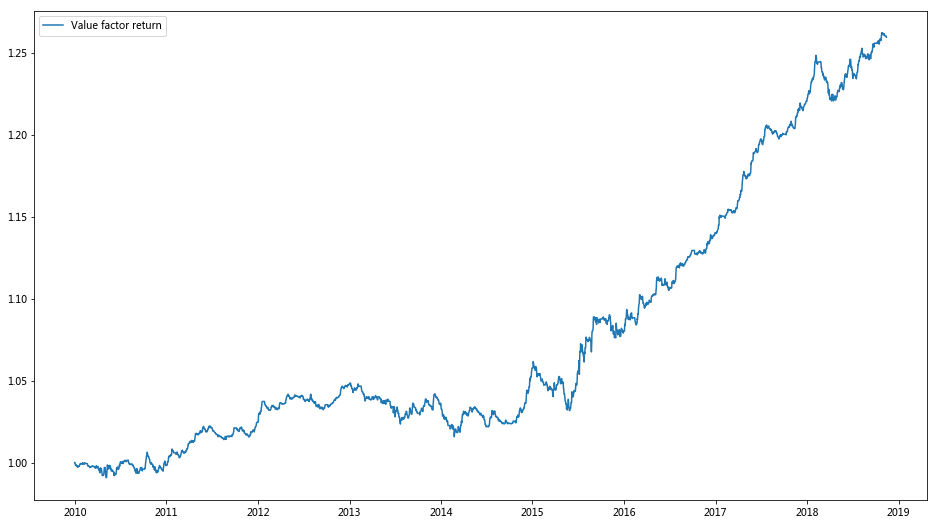

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(acc, label=u'Value factor return')
ax.legend()